In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# データ読み込み
train_data = pd.read_csv("titanic/train.csv")
test_data = pd.read_csv("titanic/test.csv")

In [2]:
# 欠損値の処理
train_data['Age'] = train_data['Age'].fillna(train_data['Age'].median())
test_data['Age'] = test_data['Age'].fillna(test_data['Age'].median())
train_data['Cabin'] = train_data['Cabin'].fillna('Unknown')
test_data['Cabin'] = test_data['Cabin'].fillna('Unknown')
train_data['Embarked'] = train_data['Embarked'].fillna(train_data['Embarked'].mode()[0])
test_data['Embarked'] = test_data['Embarked'].fillna(test_data['Embarked'].mode()[0])

# 性別を数値に変換
train_data['Sex'] = train_data['Sex'].map({'male': 0, 'female': 1})
test_data['Sex'] = test_data['Sex'].map({'male': 0, 'female': 1})

train_data["Embarked"] = train_data["Embarked"].map({"S": 0, "C": 1, "Q": 2}).astype(int)
test_data["Embarked"] = test_data["Embarked"].map({"S": 0, "C": 1, "Q": 2}).astype(int)


In [3]:
# Pythonで決定木の分類器をpruningを使ってモデリングする
from sklearn.model_selection import train_test_split
from sklearn import tree
#特微量
# 既存の特徴量から新しい特徴量を作成
train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch']
test_data['FamilySize'] = test_data['SibSp'] + test_data['Parch']
# 特微量の選択に新しい特徴量を含める
features = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'FamilySize']
X = train_data[features]
y = train_data['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#モデル決定木の訓練
model = tree.DecisionTreeClassifier(random_state=0)
path = model.cost_complexity_pruning_path(X_train, y_train)
eff_alphas, impurities = path.ccp_alphas, path.impurities
print(eff_alphas)
print(impurities)

[0.00000000e+00 4.45871232e-05 1.07009096e-04 1.09752919e-04
 1.24555122e-04 1.62203261e-04 3.81709275e-04 4.01284109e-04
 4.20392876e-04 4.28036383e-04 5.35045479e-04 5.35045479e-04
 5.50332493e-04 7.55358323e-04 7.90221015e-04 8.02568218e-04
 8.56072766e-04 8.56072766e-04 9.18729408e-04 9.51191962e-04
 9.63081862e-04 9.72809962e-04 1.00714443e-03 1.03101753e-03
 1.05387746e-03 1.05480394e-03 1.07320285e-03 1.08346709e-03
 1.20385233e-03 1.20385233e-03 1.28410915e-03 1.31329345e-03
 1.33226324e-03 1.33761370e-03 1.40449438e-03 1.51596219e-03
 1.52960060e-03 1.55248568e-03 1.55521593e-03 1.67201712e-03
 1.78062125e-03 1.81474283e-03 1.82972693e-03 1.83444164e-03
 1.93635507e-03 2.16693419e-03 2.24719101e-03 2.28286071e-03
 2.57713572e-03 2.67522739e-03 2.71277445e-03 2.82622316e-03
 2.87234941e-03 2.96058498e-03 2.96842569e-03 2.98096767e-03
 3.02143329e-03 3.05770248e-03 3.53815420e-03 3.77480383e-03
 3.85479393e-03 3.91513466e-03 4.11250643e-03 5.48795818e-03
 1.04442904e-02 1.294037

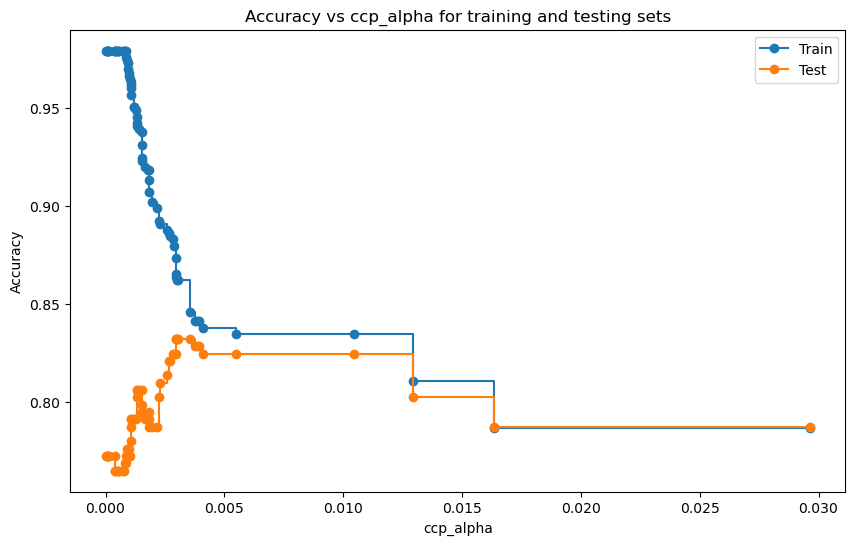

Optimal ccp_alpha: 0.002968425690796722


In [4]:
# ccp_alphaの値に対するモデルのスコアを保存するリスト
train_scores = []
test_scores = []

# 各ccp_alphaについてモデルを訓練し、スコアを計算
for ccp_alpha in eff_alphas:
    model = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    model.fit(X_train, y_train)
    train_scores.append(model.score(X_train, y_train))
    test_scores.append(model.score(X_test, y_test))

# 結果の可視化
plt.figure(figsize=(10, 6))
plt.plot(eff_alphas[:-1], train_scores[:-1], marker='o', label='Train', drawstyle="steps-post")
plt.plot(eff_alphas[:-1], test_scores[:-1], marker='o', label='Test', drawstyle="steps-post")
plt.xlabel('ccp_alpha')
plt.ylabel('Accuracy')
plt.title('Accuracy vs ccp_alpha for training and testing sets')
plt.legend()
plt.show()

# 最適なccp_alphaの値を見つける
index_of_max_test_score = np.argmax(test_scores)
optimal_ccp_alpha = eff_alphas[index_of_max_test_score]
print(f"Optimal ccp_alpha: {optimal_ccp_alpha}")
#この場合は0.002968425690796722

TtestResult(statistic=3.5654198986194974, pvalue=0.0031044044954092265, df=14)

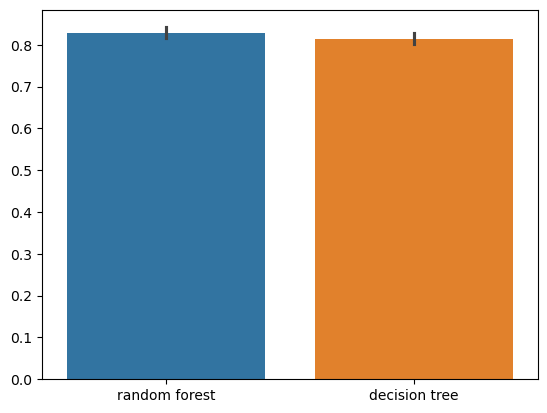

In [21]:
# モデルの構築
from sklearn.ensemble import RandomForestClassifier
# 普通の木も作成してみる
rf_model = RandomForestClassifier(random_state=0, ccp_alpha=0.004)
dt_model = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=0.004)


# 学習と評価
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=0)
rf_scores = cross_val_score(rf_model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
dt_scores = cross_val_score(dt_model, X, y, scoring="accuracy", cv=cv, n_jobs=-1)


score_df = pd.DataFrame({"random forest": rf_scores, "decision tree": dt_scores})
sns.barplot(data=score_df)

#t検定
from scipy import stats
stats.ttest_rel(score_df['random forest'], score_df['decision tree'])

<BarContainer object of 6 artists>

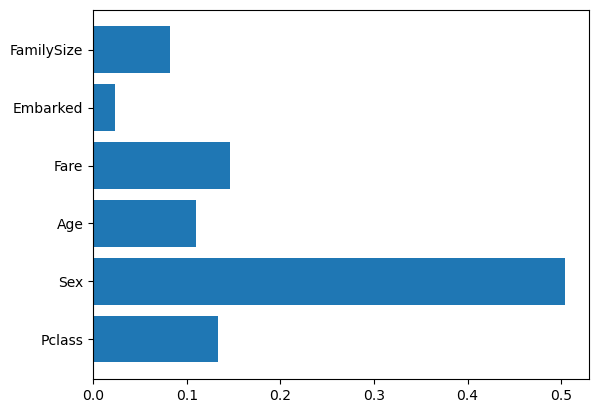

In [22]:
# 特微量の重要度
rf_model.fit(X, y)
plt.barh(X.columns, rf_model.feature_importances_)

In [23]:


# テストデータでの予測準備
X_test = test_data[features]
test_predictions = rf_model.predict(X_test)

# 提出用データフレームの作成
submission = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],
    'Survived': test_predictions
})

# CSVファイルとして保存
submission.to_csv('submission最新.csv', index=False)